the goal of this notebook is to be able to:

- take a timeseries that contains gaps
- train a GPFA Learner using the available data
- impute the gap, by using the predictions of the learner
- to improve the imputation by conditioning the distribution on the other observation at the same time stamp

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| default_exp imputation

In [ ]:
from gpfa_imputation.learner import *

import torch

import pandas as pd
import numpy as np
from fastcore.foundation import patch

import matplotlib.pyplot as plt
import altair as alt

In [ ]:
torch.manual_seed(27); # set seed for reproducibility of examples

## Fake data 

generate some fake data in order to test the imputation

What is does is:
- take a function to generate the "true" latent
- use some random coefficient to generate all the N features
- add some random noise

In [ ]:
#| export
class GPFAFakeData:
    def __init__(self,
                    n_features: int,
                    n_obs: int,
                    latent_func = lambda x: torch.sin(3*x), # Functions used to generate the true latent
                    noise_std = .2,
                    Lambda = None
                ):
        
        self.n_features, self.n_obs = n_features, n_obs
        self.time = torch.arange(0, self.n_obs, dtype=torch.float)
        
        self.latent = latent_func(self.time)
        
        self.Lambda = torch.tensor(Lambda).reshape(n_features, 1) if Lambda is not None else torch.rand(n_features, 1)
        
        self.exact_X = (self.Lambda * self.latent).T
        
        self.X =  self.exact_X + torch.normal(0., noise_std, size = (n_obs, n_features)) 
        
        self.data = pd.DataFrame(self.X.numpy(), columns = [f"x{i}" for i in range(self.n_features)]) 
        

In [ ]:
fd = GPFAFakeData(3, 4)

In [ ]:
fd_plot = pd.DataFrame(fd.X.numpy(), columns = ["x1", "x2", "x3"])
fd_plot["latent"] = pd.Series(fd.latent.numpy())

<AxesSubplot: >

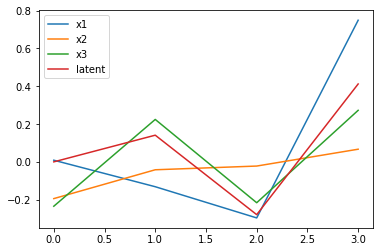

In [ ]:
fd_plot.plot()

### Missing Data

add to the fake data class the ability to generate some missing data

In [ ]:
@patch()
def add_random_missing(self: GPFAFakeData,
                prob_miss_row: float = .2,#  Probability an entire row is missing
                prob_miss_value: float = .1 # Probability a single observation is missing       
               ):
    """Make some row and same values randomly missing """
    # keep the original data
    self.data_complete = self.data.copy()
        
    self.is_miss_row = torch.rand(self.n_obs) <= prob_miss_row
    
    self.data[self.is_miss_row.numpy()] = np.nan
    
    self.is_miss_value = (torch.rand(self.n_obs * self.n_features) <= prob_miss_value).reshape(-1, self.n_features)
    
    self.data[self.is_miss_value.numpy()] = np.nan
    
    return self

In [ ]:
fd.add_random_missing().data

,x0,x1,x2
0,0.008676,-0.194478,-0.234784
1,-0.131580,-0.041877,0.224467
2,-0.296656,-0.022229,-0.216300
3,0.749373,0.066919,0.272668


In [ ]:
GPFAFakeData(2, 10).add_random_missing(prob_miss_value = .7, prob_miss_row=.0).data

,x0,x1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,-0.141661,NaN
4,NaN,-0.260047
5,NaN,NaN
6,NaN,NaN
7,0.214413,NaN
8,NaN,NaN
9,NaN,NaN


### Save as DataFrame

In [ ]:
@patch
def tidy_df(self: GPFAFakeData,
          complete = False, # full dataset (False) or the one with missing data (True)
          is_missing = False # add flag whether value is missing
         ):
    
    df = self.data if not complete else self.data_complete # no need to copy here because next lines does a copy anyway
    df = df.assign(time = self.time.numpy())
        
    df = df.melt("time")
    
    if is_missing: df = df.assign(is_missing = self.data.melt().value.isna()) #missing data is not from complete data
        
    return df

In [ ]:
fd.tidy_df()

,time,variable,value
0,0.0,x0,0.008676
1,1.0,x0,-0.131580
2,2.0,x0,-0.296656
3,3.0,x0,0.749373
4,0.0,x1,-0.194478
5,1.0,x1,-0.041877
6,2.0,x1,-0.022229
7,3.0,x1,0.066919
8,0.0,x2,-0.234784
9,1.0,x2,0.224467


In [ ]:
fd.tidy_df(complete=True)

,time,variable,value
0,0.0,x0,0.008676
1,1.0,x0,-0.131580
2,2.0,x0,-0.296656
3,3.0,x0,0.749373
4,0.0,x1,-0.194478
5,1.0,x1,-0.041877
6,2.0,x1,-0.022229
7,3.0,x1,0.066919
8,0.0,x2,-0.234784
9,1.0,x2,0.224467


In [ ]:
fd.tidy_df(complete=False, is_missing=True)

,time,variable,value,is_missing
0,0.0,x0,0.008676,False
1,1.0,x0,-0.131580,False
2,2.0,x0,-0.296656,False
3,3.0,x0,0.749373,False
4,0.0,x1,-0.194478,False
5,1.0,x1,-0.041877,False
6,2.0,x1,-0.022229,False
7,3.0,x1,0.066919,False
8,0.0,x2,-0.234784,False
9,1.0,x2,0.224467,False


The export as a dataframe is working correctly with the missing data

In [ ]:
fd_df = fd.tidy_df()

In [ ]:
alt.Chart(fd_df).mark_line(point=True).encode(
    x = "time",
    y = "value",
    color = "variable"
)

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [ ]:
fd.data

,x0,x1,x2
0,0.008676,-0.194478,-0.234784
1,-0.131580,-0.041877,0.224467
2,-0.296656,-0.022229,-0.216300
3,0.749373,0.066919,0.272668


## GPFA Imputation

This is the core class that does the imputation using a GPFA

The inputs is:

- a dataframe containing the observed data, where the row with missing data have been removed
- a vector of times where the data is missing

it returns:

- a complete dataframe with the prediction of the model

The goal is that `GPFAImputation` takes as imput a dataframe containing missing values and then it imputes them using GPFALearner.
Therefore it needs to divide the dataframe in 3 sections:

- training data (rows with no NAs)
- times to be imputed (rows with some NAs)
- observations (variables in the pred rows that are not missing) for conditional predictions

In [ ]:
t_df = pd.DataFrame([
    [1., 3., 4.],
    [2., 6., np.nan],
    [np.nan, np.nan, np.nan],
    [np.nan, 8., np.nan],
    [3., 4., 5.]
]
)

In [ ]:
train_idx = ~t_df.isna().any(1)

/tmp/ipykernel_97617/3664883938.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  train_idx = ~t_df.isna().any(1)


In [ ]:
t_df[train_idx]

,0,1,2
0,1.0,3.0,4.0
4,3.0,4.0,5.0


In [ ]:
pred_data = t_df[~train_idx].to_numpy() 

In [ ]:
pred_data

array([[ 2.,  6., nan],
       [nan, nan, nan],
       [nan,  8., nan]])

In [ ]:
idx_cond = ~t_df[~train_idx].isna()

In [ ]:
idx_cond

,0,1,2
1,True,True,False
2,False,False,False
3,False,True,False


In [ ]:
#idx_cond = idx_cond.to_numpy().flatten() # learner needs a 1D index

#pred_data.flatten()[idx_cond]

#train_idx = t_df.isna().any(axis=1)

#torch.tensor(~t_df[~train_idx].isna().to_numpy().flatten())

Implement this into a function

In [ ]:
#| export
class GPFAImputation:
    def __init__(
        self,
        data: pd.DataFrame , #observed data with missing data as NA
    ):
        self.data = data
        self.T = torch.arange(0, len(data), dtype=torch.float32) # time is encoded with a increase of 1
        
        # Training data
        self.train_idx = ~self.data.isna().any(axis=1)
        self.train_data = torch.tensor(self.data[self.train_idx].to_numpy())
        self.train_T = self.T[self.train_idx]
        
        self.learner = GPFALearner(X = self.train_data, T = self.train_T)

        # Prediction data
        self.pred_T = self.T[~self.train_idx]
        self.cond_idx = torch.tensor(~self.data[~self.train_idx].isna().to_numpy().flatten()) # conditional obsevations
        self.cond_obs = torch.tensor(self.data[~self.train_idx].to_numpy().flatten()[self.cond_idx])
        
        
    def impute(self,
               add_time = True, # add column with time?
               tidy = True # tidy data?
               ):
        self.learner.train()
        self.pred = self.learner.predict(self.pred_T, obs = self.cond_obs, idx = self.cond_idx)
        
        if tidy: return self._impute_tidy(add_time)
        else: return self._impute_wide(add_time)
        
        
    def _impute_wide(self, add_time):
        """ Impute in wide format"""
        
        imp_data = self.data.copy()
        for col_idx, col_name in enumerate(imp_data.columns):
            imp_data.loc[~self.train_idx, col_name] = self.pred.mean[:, col_idx].numpy()
            imp_data.loc[~self.train_idx, col_name + "_std"] = self.pred.std[:, col_idx].numpy()
        
        idx_vars = []
        if add_time:
            imp_data["time"] = self.T
            idx_vars.append("time")
        
        return imp_data 
    
    def _impute_tidy(self, add_time):
        """ transform the pred output into a tidy dataframe suitable for plotting"""
        feature_names = self.data.columns

        pred_mean = pd.DataFrame(self.pred.mean, columns = feature_names).assign(time = self.pred_T).melt("time", value_name="mean")
        pred_std = pd.DataFrame(self.pred.std, columns = feature_names).assign(time = self.pred_T).melt("time", value_name="std")
        
        pred = pd.merge(pred_mean, pred_std, on=['time', 'variable'])  
        
        train_data = self.data[self.train_idx].assign(time = self.train_T).melt("time", value_name = "mean")
               
        imp_data = pd.concat((train_data, pred))
        
        return imp_data
    

In [ ]:
fd = GPFAFakeData(2, 10, Lambda=[1,2.]).add_random_missing()

In [ ]:
fd.data

,x0,x1
0,0.041010,-0.155358
1,0.393050,0.496807
2,-0.378371,NaN
3,0.340304,0.932448
4,-0.595726,-1.212931
5,0.856908,1.033006
6,-0.755094,-1.531880
7,0.844316,1.282393
8,NaN,NaN
9,1.006589,1.710613


In [ ]:
imp = GPFAImputation(fd.data)

In [ ]:
pred = imp.impute()
pred

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: operator() profile_node %840 : int[] = prim::profile_ivalue(%838)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  Variable._execution_engine.run_backward(  # Calls into the C++ eng

,time,variable,mean,std
0,0.0,x0,0.041010,NaN
1,1.0,x0,0.393050,NaN
2,3.0,x0,0.340304,NaN
3,4.0,x0,-0.595726,NaN
4,5.0,x0,0.856908,NaN
5,6.0,x0,-0.755094,NaN
6,7.0,x0,0.844316,NaN
7,9.0,x0,1.006589,NaN
8,0.0,x1,-0.155358,NaN
9,1.0,x1,0.496807,NaN


In [ ]:
imp.impute(tidy=False)

,x0,x1,x0_std,x1_std,time
0,0.041010,-0.155358,NaN,NaN,0.0
1,0.393050,0.496807,NaN,NaN,1.0
2,-0.378371,-0.807404,0.000000,0.212507,2.0
3,0.340304,0.932448,NaN,NaN,3.0
4,-0.595726,-1.212931,NaN,NaN,4.0
5,0.856908,1.033006,NaN,NaN,5.0
6,-0.755094,-1.531880,NaN,NaN,6.0
7,0.844316,1.282393,NaN,NaN,7.0
8,0.266420,0.319387,0.621827,1.107246,8.0
9,1.006589,1.710613,NaN,NaN,9.0


### Prediction plot

In [ ]:
@patch()
def plot_pred(
    self: GPFAImputation,
    complete = None # Optional true data to be plotted agaist predictions
):
    
    imp = self._impute_tidy(add_time=True) if hasattr(self, "pred") else self.impute(tidy=True, add_time=True)
    
    error = alt.Chart(imp).mark_errorband().encode(
        x = "time",    
        y = alt.Y("err_low:Q", title=""),
        y2 = "err_high:Q",
        color="variable"
    ).transform_calculate(
        err_low = "datum.mean - 2 * datum.std",
        err_high = "datum.mean + 2 * datum.std"
    )

    pred = alt.Chart(imp).mark_line().encode(
        x = "time",    
        y = alt.Y("mean:Q", title="value variable"),
        color="variable"
    )

    plot = error + pred
    
    if complete is not None:
        
        truth_plt = alt.Chart(complete).mark_point().encode(
            x = "time",
            y = alt.Y("value", title="value variable"),
            color="variable",
            shape = "is_missing"
        )
        
        plot = plot + truth_plt
    
    
    return plot

In [ ]:
imp.plot_pred(complete = fd.tidy_df(complete=True, is_missing=True))

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [ ]:
imp.plot_pred()

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

The code is running correctly and as expected around the missing data point the error is band is wider

In [ ]:
pred_data

array([[ 2.,  6., nan],
       [nan, nan, nan],
       [nan,  8., nan]])

In [ ]:
idx_cond = ~t_df[~train_idx].isna()

In [ ]:
idx_cond

,0,1,2
0,True,True,True
4,True,True,True


In [ ]:
idx_cond = idx_cond.to_numpy().flatten() # learner needs a 1D index

In [ ]:
obs = pred_data.flatten()[idx_cond]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 9 but corresponding boolean dimension is 6

In [ ]:
obs

In [ ]:
train_idx = t_df.isna().any(axis=1)

In [ ]:
torch.tensor(~t_df[~train_idx].isna().to_numpy().flatten())

Implement this into a function

In [ ]:
#| export
class GPFAImputation:
    def __init__(
        self,
        data: pd.DataFrame , #observed data with missing data as NA
    ):
        self.data = data
        self.T = torch.arange(0, len(data), dtype=torch.float32) # time is encoded with a increase of 1
        
        # Training data
        self.train_idx = ~self.data.isna().any(axis=1)
        self.train_data = torch.tensor(self.data[self.train_idx].to_numpy())
        self.train_T = self.T[self.train_idx]
        
        self.learner = GPFALearner(X = self.train_data, T = self.train_T)

        # Prediction data
        self.pred_T = self.T[~self.train_idx]
        self.cond_idx = torch.tensor(~self.data[~self.train_idx].isna().to_numpy().flatten()) # conditional obsevations
        self.cond_obs = torch.tensor(self.data[~self.train_idx].to_numpy().flatten()[self.cond_idx])
        
        
    def impute(self,
               add_time = True, # add column with time?
               tidy = True # tidy data?
               ):
        self.learner.train()
        self.pred = self.learner.predict(self.pred_T, obs = self.cond_obs, idx = self.cond_idx)
        
        if tidy: return self._impute_tidy(add_time)
        else: return self._impute_wide(add_time)
        
        
    def _impute_wide(self, add_time):
        """ Impute in wide format"""
        
        imp_data = self.data.copy()
        for col_idx, col_name in enumerate(imp_data.columns):
            imp_data.loc[~self.train_idx, col_name] = self.pred.mean[:, col_idx].numpy()
            imp_data.loc[~self.train_idx, col_name + "_std"] = self.pred.std[:, col_idx].numpy()
        
        idx_vars = []
        if add_time:
            imp_data["time"] = self.T
            idx_vars.append("time")
        
        return imp_data 
    
    def _impute_tidy(self, add_time):
        """ transform the pred output into a tidy dataframe suitable for plotting"""
        feature_names = self.data.columns

        pred_mean = pd.DataFrame(self.pred.mean, columns = feature_names).assign(time = self.pred_T).melt("time", value_name="mean")
        pred_std = pd.DataFrame(self.pred.std, columns = feature_names).assign(time = self.pred_T).melt("time", value_name="std")
        
        pred = pd.merge(pred_mean, pred_std, on=['time', 'variable'])  
        
        train_data = self.data[self.train_idx].assign(time = self.train_T).melt("time", value_name = "mean")
               
        imp_data = pd.concat((train_data, pred))
        
        return imp_data
    

In [ ]:
fd = GPFAFakeData(2, 10, Lambda=[1,2.]).add_random_missing()

In [ ]:
fd.data

In [ ]:
imp = GPFAImputation(fd.data)

In [ ]:
pred = imp.impute()
pred

In [ ]:
imp.impute(tidy=False)

### Prediction plot

In [ ]:
@patch()
def plot_pred(
    self: GPFAImputation,
    complete = None # Optional true data to be plotted agaist predictions
):
    
    imp = self._impute_tidy(add_time=True) if hasattr(self, "pred") else self.impute(tidy=True, add_time=True)
    
    error = alt.Chart(imp).mark_errorband().encode(
        x = "time",    
        y = alt.Y("err_low:Q", title=""),
        y2 = "err_high:Q",
        color="variable"
    ).transform_calculate(
        err_low = "datum.mean - 2 * datum.std",
        err_high = "datum.mean + 2 * datum.std"
    )

    pred = alt.Chart(imp).mark_line().encode(
        x = "time",    
        y = alt.Y("mean:Q", title="value variable"),
        color="variable"
    )

    plot = error + pred
    
    if complete is not None:
        
        truth_plt = alt.Chart(complete).mark_point().encode(
            x = "time",
            y = alt.Y("value", title="value variable"),
            color="variable",
            shape = "is_missing"
        )
        
        plot = plot + truth_plt
    
    
    return plot

In [ ]:
imp.plot_pred(complete = fd.tidy_df(complete=True, is_missing=True))

In [ ]:
imp.plot_pred()

The code is running correctly and as expected around the missing data point the error is band is wider

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()